# <span style=" display: block; text-align: center; color: #FFFFFF; padding: 0.4em 0.5em;background: #303030;">  Compression with DWT  </span>





# <span style="padding: 0.4em 0.5em; color: #494949; background: #f4f4f4; border-left: solid 5px #7db4e6; border-bottom: solid 3px #d7d7d7;">1. Compression of an image</span>

The DWT(Discrete Wavelet Transform) image has a lot of zeros/low values, that do not carry relevant visual information of the image.
<p/>
<img src="img/dwtLena.png" width=512>
<p/>
That is why we can compress with a high rate and get a file which is much smaller (in Ko) than the original bmp image. That is what you will verify in this section!

Note that this should be true for Lena image, but maybe not for imSynth image, which already have lots of 0 and identical values :).


## <span style="border-bottom: double 5px #7db4e6; color: #494949;">1.1. Build a DWT image using quantization</span>

**In this section, we want to save the dwt image in a file (to compress it and analyse the compression rate). But before, we will add quantization of the different part (sub-bands) of the image**.

First of all, we verify that the quantization does not deteriorate too much the original image. To do that, we will use the following code:
<p/>
<img src="img/code10.png" width=600>
<p/>
We put the previous code in functions (decomposition, reconstruction, verification). Those functions are in the python file <b>usefullDwtFunctions.py</b>.
<br/><br/><br/>
The new functions for saving dwt image using quantization are introduced below. 

### <span style="">1.1.1. Understand the values of each sub-band</span>

LL, LH, HL and HH are called sub-bands, for they result from different filters. Observe the values of each subband. 

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
from waveletsaveimage import usefullDwtFunctions as uf

#img = cv2.imread('img/imsynth.bmp',cv2.IMREAD_GRAYSCALE) # read the image
img = cv2.imread('img/lena.bmp',cv2.IMREAD_GRAYSCALE) # read the image
print("")
print("The image is " + str(len(img[0])) + " pixels wide and " + str(len(img)) + " pixels high.")


#------------------------------
# MAIN PROCESS SAVING IMAGE WITH DWT
# Save data in a file and rebuild
#------------------------------
coefMult = 8

# encoding 
[imgLL1, imgLH1, imgHL1, imgHH1] = uf.decomposition(img)



The image is 512 pixels wide and 512 pixels high.

Image with max amplitude : 244
Starting decomposition...
Decommposition finished
Max amplitude of integer images are : 244 (0 filter), 1992.0 608.0 (1 filter), 16800.0 3200.0 5088.0 2560.0 (2 filters)
Min amplitude of integer images are : 28 (0 filter), 0.0 -544.0 (1 filter), 0.0 -3072.0 -4288.0 -3584.0 (2 filters)
The images are 256 pixels wide and 256 pixels high.


Explain those values.

### <span style="">1.1.2.  Understand the quantization function</span>

To save the dwt image (LL, HL, LH, and HH) as a bmp with the same size as the original, we should quantify **the signal is 8 bits (values between 0 and 255)**. 

One solution is proposed in the following code. Read and understand this solution:
  

In [8]:
# Quantization 图像量化
def quantizationForSaving(img, sign):
    print("Quantization...")
    if sign: # if we want to keep negative values, we encode the value on 7 bits and save le sign as the 8th bit
        coef=2**(15-7) # we encode the 15 bits on 7 bits
        imgSign = np.sign(img)
        img_comp = np.abs(img)//coef*2 # quantification - we keep the high level information
        img_comp = img_comp + np.where(imgSign==-1, 0, imgSign) # add the sign as the 8th bit符号比特
    else:
        coef=2**(15-8) # we encode the 15 bits on 8 bits
        imgSign = np.sign(img)
        img_comp = np.multiply(img,np.where(imgSign==-1, 0, imgSign))//coef # we keep the positive values only for encoding
    print("Max amplitude of image goes from : " +  str(np.max(img)) + " to : " +  str(np.max(img_comp)))
    print("Min amplitude of image goes from : " +  str(np.min(img)) + " to : " +  str(np.min(img_comp)))
    return [img_comp, 0]

### <span style="">1.1.3. Save the dwt image in a bmp file</span>

Then complete the code for saving the dwt image:

In [9]:
# Save an image from dwt
def saveImageFromSubBands(LL, LH, HL, HH, name):
    img_dwt = np.zeros((2*LL.shape[0], 2*LL.shape[1]))
    listOffsets = [0, 0, 0, 0] # 偏移量/补偿量
    [img_dwt[0:LL.shape[0], 0:LL.shape[1]], listOffsets[0]] = quantizationForSaving(LL, False) # for LL, we mainly have positive values
    [img_dwt[LL.shape[0]:LL.shape[0]+HL.shape[0], 0:HL.shape[1]], listOffsets[1]] = quantizationForSaving(HL, True)
    [img_dwt[0:LL.shape[0], LL.shape[1]:LL.shape[1]+LH.shape[0]], listOffsets[2]] = quantizationForSaving(LH, True)
    [img_dwt[LL.shape[0]:LL.shape[0]+HH.shape[0], LL.shape[1]:LL.shape[1]+HH.shape[0]], listOffsets[3]] = quantizationForSaving(HH, True)
    cv2.imwrite(name+'.bmp',img_dwt) # write the image
    return [img_dwt, listOffsets]

<div id="back_1">
   <a href="#sol_1">Go to one solution.</a>
</div>

Verify with the full code.

In [4]:
# Open an image with dwt
def openImageGetSubBands(name, listoffset):
    # do the opposit treatment as "saveImageFromSubBands"
    img = cv2.imread(name,cv2.IMREAD_GRAYSCALE)
    step = img.shape[0]//2 # we suppose we have a square
    coef=2**(15-8) # for LL, the value is endoded on 8 bits
    tmp = img[0:step, 0:step].astype(float)
    LL = coef*tmp
    coef=2**(15-7) # the value is endoded on 7 bits and the 8th bit is the sign
    tmp = img[step:2*step, 0:step].astype(float)
    HL = coef*((tmp//2)*(tmp%2*2-1))
    tmp = img[0:step, step:2*step].astype(float)
    LH = coef*((tmp//2)*(tmp%2*2-1))
    tmp = img[step:2*step, step:2*step].astype(float)
    HH = coef*((tmp//2)*(tmp%2*2-1))
    return [LL, LH, HL, HH]


The image is 512 pixels wide and 512 pixels high.

Image with max amplitude : 244
Starting decomposition...
Decommposition finished
Max amplitude of integer images are : 244 (0 filter), 1992.0 608.0 (1 filter), 16800.0 3200.0 5088.0 2560.0 (2 filters)
Min amplitude of integer images are : 28 (0 filter), 0.0 -544.0 (1 filter), 0.0 -3072.0 -4288.0 -3584.0 (2 filters)
The images are 256 pixels wide and 256 pixels high.
Quantization...
Max amplitude of image goes from : 16800.0 to : 131.0
Min amplitude of image goes from : 0.0 to : 0.0
Quantization...
Max amplitude of image goes from : 5088.0 to : 39.0
Min amplitude of image goes from : -4288.0 to : 0.0
Quantization...
Max amplitude of image goes from : 3200.0 to : 25.0
Min amplitude of image goes from : -3072.0 to : 0.0
Quantization...
Max amplitude of image goes from : 2560.0 to : 28.0
Min amplitude of image goes from : -3584.0 to : 0.0


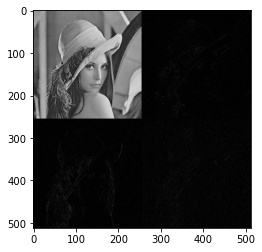

In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
from waveletsaveimage import usefullDwtFunctions as uf

#img = cv2.imread('img/imsynth.bmp',cv2.IMREAD_GRAYSCALE) # read the image
img = cv2.imread('img/lena.bmp',cv2.IMREAD_GRAYSCALE) # read the image
print("")
print("The image is " + str(len(img[0])) + " pixels wide and " + str(len(img)) + " pixels high.")


#------------------------------
# MAIN PROCESS SAVING IMAGE WITH DWT
# Save data in a file and rebuild
#------------------------------
coefMult = 8

# encoding 
[imgLL1, imgLH1, imgHL1, imgHH1] = uf.decomposition(img)

# Plot and Save image from subbands
[imgdwt, listoffsets] = saveImageFromSubBands(imgLL1, imgLH1, imgHL1, imgHH1, "dwt")
plt.figure()
plt.imshow(imgdwt, cmap = 'gray')
plt.show()

# Open dwt image
[imgLL1, imgLH1, imgHL1, imgHH1] = openImageGetSubBands("dwt.bmp", listoffsets) # we should save the listoffsets in the header of the image :)



Verify that the dwt bmp file is saved on your disk. Open it to verify the image.


## <span style="border-bottom: double 5px #7db4e6; color: #494949;">1.2. Verify the DWT image</span>

Verify the reconstruction of the image from the data of the dwt file.
What do you notice? How can you explain it? 


Starting recontruction...
Reconstruction finished
Max amplitude of integer images are : 16768.0 3072.0 4864.0 2560.0 (0 filter), 134144.0 20992.0 38912.0 17408.0 126976.0 37888.0 (1 filter) 1015808.0 259328.0 1001472.0 (2 filters)
Min amplitude of integer images are : 0.0 -3072.0 -4096.0 -3584.0 (0 filter), 0.0 -22016.0 -32768.0 -23296.0 0.0 -33792.0 (1 filter) 0.0 -218624.0 0.0 (2 filters)
The image is 512 pixels wide and 512 pixels high.

Starting verification...
Mask delta value : 8.0


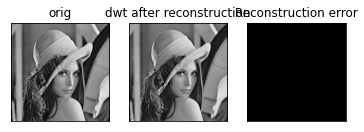

In [10]:
# reconstruction
imgR1 = uf.reconstruction(imgLL1, imgLH1, imgHL1, imgHH1)
uf.verification(img, 'orig', imgR1//coefMult**4, 'dwt after reconstruction', 6)

# <span style="padding: 0.4em 0.5em; color: #494949; background: #f4f4f4; border-left: solid 5px #7db4e6; border-bottom: solid 3px #d7d7d7;">2. Towards JPEG200</span>

Dwt is used in JPEG2000. One of the main difference with JPEG is the use of wavelets. Let's look at some more ways to use wavelets to save the image.

Note that many other solutions can be imagine to reduce the number of information (compression). 

## <span style="border-bottom: double 5px #7db4e6; color: #494949;">2.1. Quantization of sub-bands</span>

We can also imagine a better quantization of sub-bands that the one proposed.

For instance, the number of bits can be lower for HL, LH and HH sub-bands, for they contain less relevant information.
Look at the min and max values of each sub-band and propose a quantization for each sub-band.


 
<div id="back_2">
   <a href="#sol_2">Go to one solution.</a>
</div>

## <span style="border-bottom: double 5px #7db4e6; color: #494949;">2.2. Multi-resolution encoding</span>

Using dwt, **most of the information is encoded in LL sub-band. Multi-resolution encoding consist at performing iteratively dwt on the LL sub-bands**.

The resulting image for a 3 level decomposition is:
    <img src="img/lena3decomp.png" width=600>

Propose a quantization for the different parts and compute the size of the final file.

Compare the size of a bmp file, a JPEG file and a JPEG2000 file.

<div id="back_3">
   <a href="#sol_3">Go to one solution.</a>
</div>

# <span style=" display: block; text-align: center; color: #FFFFFF; padding: 0.4em 0.5em;background: #303030;">  Solutions </span>

<div id="sol_1"/>


# 1.1.3. Save the dwt image in a bmp file

In [8]:
# Save an image from dwt
def saveImageFromSubBands(LL, LH, HL, HH, name):
    img_dwt = np.zeros((2*LL.shape[0], 2*LL.shape[1]))
    listOffsets = [0, 0, 0, 0]
    [img_dwt[0:LL.shape[0], 0:LL.shape[1]], listOffsets[0]] = quantizationForSaving(LL, False) # for LL, we mainly have positive values
    [img_dwt[LL.shape[0]:LL.shape[0]+HL.shape[0], 0:HL.shape[1]], listOffsets[1]] = quantizationForSaving(HL, True)
    [img_dwt[0:LL.shape[0], LL.shape[1]:LL.shape[1]+LH.shape[0]], listOffsets[2]] = quantizationForSaving(LH, True)
    [img_dwt[LL.shape[0]:LL.shape[0]+HH.shape[0], LL.shape[1]:LL.shape[1]+HH.shape[0]], listOffsets[3]] = quantizationForSaving(HH, True)
    cv2.imwrite(name+'.bmp',img_dwt) # write the image
    return [img_dwt, listOffsets]

   <a href="#back_1">Back.</a>

<div id="sol_2"/>

# 2.1. Quantization of sub-bands

Having a 1-level decomposition with: 8 bits for LL, 7 bits for HL and LH and 5 bits for HH will reduce the size of the bmp image from 32 768 to 27 648, with few loss. If we couple that with multi-resolution (see next paragraph), we can gain even more.

   <a href="#back_2">Back.</a>

<div id="sol_3"/>

# 2.2. Multi-resolution encoding

With Lean file:
BMP file is 263 Ko
JPEG file is 91 Ko
JPEG2000 depends on the compression rate. Example: the following file is only 10Ko.
 <img src="img/lena.jp2" width=512>

   <a href="#back_3">Back.</a>